In [41]:
import pandas as pd
import pandas as pd


# df_original = pd.read_csv("drive/MyDrive/Datasets/chembl_200_dump.csv")
# df_original = pd.read_csv("drive/MyDrive/Datasets/chembl_subset4.csv")
df_original = pd.read_csv("drive/MyDrive/Datasets/chembl_enhanced_dump200.csv")

In [42]:
df = df_original.copy()
print(len(df))
df.head()

200000


,activity_id,assay_id,chembl_id,standard_inchi_key,canonical_smiles,standard_type,standard_value,standard_units,standard_relation,pchembl_value,...,hbd,psa,rtb,num_ro5_violations,max_phase,target_name,organism,assay_type,bao_format,confidence_score
0,205843,230853,CHEMBL6329,OWRSAHYFSSNENM-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,pH1/2,7.08,NaN,=,NaN,...,1.0,84.82,3.0,0.0,NaN,No relevant target,NaN,P,BAO_0000100,0
1,205844,63480,CHEMBL6329,OWRSAHYFSSNENM-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,MEC,60.00,p.p.m.,=,NaN,...,1.0,84.82,3.0,0.0,NaN,Eimeria tenella,NaN,F,BAO_0000218,1
2,190321,230853,CHEMBL6328,ZJYUMURGSZQFMH-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,pH1/2,7.08,NaN,=,NaN,...,1.0,108.61,3.0,0.0,NaN,No relevant target,NaN,P,BAO_0000100,0
3,190322,63480,CHEMBL6328,ZJYUMURGSZQFMH-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,MEC,125.00,p.p.m.,=,NaN,...,1.0,108.61,3.0,0.0,NaN,Eimeria tenella,NaN,F,BAO_0000218,1
4,207044,63480,CHEMBL265667,YOMWDCALSDWFSV-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,MEC,30.00,p.p.m.,=,NaN,...,2.0,87.98,3.0,0.0,NaN,Eimeria tenella,NaN,F,BAO_0000218,1


In [43]:
print(df.columns.tolist())

['activity_id', 'assay_id', 'chembl_id', 'standard_inchi_key', 'canonical_smiles', 'standard_type', 'standard_value', 'standard_units', 'standard_relation', 'pchembl_value', 'data_validity_comment', 'activity_comment', 'potential_duplicate', 'bao_endpoint', 'mw_freebase', 'alogp', 'hba', 'hbd', 'psa', 'rtb', 'num_ro5_violations', 'max_phase', 'target_name', 'organism', 'assay_type', 'bao_format', 'confidence_score']


# 🧬 Uzasadnienie doboru cech (kolumn) z bazy ChEMBL

Poniższy zestaw kolumn został wyselekcjonowany w celu zbudowania rzetelnego zbioru danych treningowych dla modelu hybrydowego (**GNN + dane tabelaryczne**). Wybór podyktowany był koniecznością precyzyjnego filtrowania danych, zapewnienia wysokiej jakości chemicznej oraz dostarczenia modelowi kluczowych właściwości fizykochemicznych.

### 1. Reprezentacja Chemiczna (Wejście dla GNN)
* **`canonical_smiles`**: Kluczowa kolumna zawierająca zapis struktury cząsteczki w formacie tekstowym. Jest to bezpośrednie wejście do generowania grafów molekularnych (węzły i krawędzie).

### 2. Identyfikacja i Deduplikacja
* **`standard_inchi_key`**: Unikalny hash struktury. Niezbędny do **agregacji** wielu pomiarów dla tego samego związku.
* **`chembl_id`, `activity_id`, `assay_id`**: Unikalne identyfikatory związku, pomiaru i eksperymentu. Pozwalają na pełną identyfikowalność (*traceability*) danych.

### 3. Zmienne Celu (Target) i Standaryzacja
* **`pchembl_value`**: Znormalizowana miara aktywności (np. `-log10(IC50)`). Główna **zmienna celu (label)** dla modelu regresji.
* **`standard_value`, `standard_units`, `standard_type`**: Surowe wyniki pomiarów. Niezbędne do ręcznego przeliczenia lub imputacji, gdy brak `pchembl_value`.
* **`standard_relation`**: Kluczowa dla filtrowania. Pozwala odrzucić wyniki nieprecyzyjne (np. `>10000 nM`).

### 4. Jakość Danych i Filtrowanie
* **`data_validity_comment`, `activity_comment`**: Uwagi o błędach. Używane do oczyszczania zbioru z danych niskiej jakości.
* **`potential_duplicate`**: Flaga wskazująca duplikaty do usunięcia.
* **`confidence_score`**: Ocena pewności przypisania testu do białka (0-9).

### 5. Właściwości Fizykochemiczne (Cechy Tabelaryczne)
Te kolumny stanowią dodatkowe wejście (*features*) dla modelu, opisując ogólne właściwości cząsteczki (związane m.in. z **Regułą Piątki Lipińskiego**):
* **`mw_freebase`**: Masa cząsteczkowa.
* **`alogp`**: Lipofilowość.
* **`hba`, `hbd`**: Liczba donorów i akceptorów wiązań wodorowych.
* **`psa`**: Polarna powierzchnia dostępna dla rozpuszczalnika.
* **`rtb`**: Liczba wiązań rotacyjnych (elastyczność).
* **`num_ro5_violations`**: Liczba naruszeń reguł Lipińskiego (*drug-likeness*).

### 6. Metadane Eksperymentalne (Kontekst)
* **`target_name`, `organism`**: Niezbędne do filtrowania danych dla konkretnego celu (np. EGFR, *Homo sapiens*).
* **`assay_type`**: Typ testu (np. wiązanie vs funkcjonalny).
* **`bao_format`**, **`bao_endpoint`**: Terminologia BioAssay Ontology (np. *cell-based* vs *biochemical*).
* **`max_phase`**: Status kliniczny leku (np. faza 4 = lek zatwierdzony).

In [44]:
print(df['data_validity_comment'].unique())

[nan 'Outside typical range' 'Potential missing data'
 'Potential transcription error' 'Manually validated']


In [45]:
print(df['data_validity_comment'].value_counts(dropna=False))

data_validity_comment
NaN                              196731
Outside typical range              3190
Potential transcription error        66
Potential missing data               11
Manually validated                    2
Name: count, dtype: int64


In [46]:
invalid_comments = [
    'Outside typical range',
    'Potential transcription error',
    'Potential missing data',
    'Potential author error'
]

df = df[~df['data_validity_comment'].isin(invalid_comments)]

In [47]:
print(len(df))

196733


In [48]:
print(df.dtypes)

activity_id                int64
assay_id                   int64
chembl_id                 object
standard_inchi_key        object
canonical_smiles          object
standard_type             object
standard_value           float64
standard_units            object
standard_relation         object
pchembl_value            float64
data_validity_comment     object
activity_comment          object
potential_duplicate        int64
bao_endpoint              object
mw_freebase              float64
alogp                    float64
hba                      float64
hbd                      float64
psa                      float64
rtb                      float64
num_ro5_violations       float64
max_phase                float64
target_name               object
organism                  object
assay_type                object
bao_format                object
confidence_score           int64
dtype: object


In [49]:
df.info()
df.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
Index: 196733 entries, 0 to 199999
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   activity_id            196733 non-null  int64  
 1   assay_id               196733 non-null  int64  
 2   chembl_id              196733 non-null  object 
 3   standard_inchi_key     196733 non-null  object 
 4   canonical_smiles       196733 non-null  object 
 5   standard_type          196701 non-null  object 
 6   standard_value         158053 non-null  float64
 7   standard_units         143001 non-null  object 
 8   standard_relation      152852 non-null  object 
 9   pchembl_value          31355 non-null   float64
 10  data_validity_comment  2 non-null       object 
 11  activity_comment       87245 non-null   object 
 12  potential_duplicate    196733 non-null  int64  
 13  bao_endpoint           196733 non-null  object 
 14  mw_freebase            196733 non-null  f

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
activity_id,196733.0,NaN,NaN,NaN,11140589.045808,8212239.052755,31889.0,2697177.0,12212543.0,17366675.0,29011198.0
assay_id,196733.0,NaN,NaN,NaN,1092149.068651,702423.782045,5.0,580386.0,887783.0,1640282.0,2596669.0
chembl_id,196733,1901,CHEMBL8,19616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
standard_inchi_key,196733,1901,MYSWGUAQZAJSOK-UHFFFAOYSA-N,19616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
canonical_smiles,196733,1901,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,19616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
standard_type,196701,1343,MIC,22964,NaN,NaN,NaN,NaN,NaN,NaN,NaN
standard_value,158053.0,NaN,NaN,NaN,111511.114503,2870115.489473,-88200.0,2.0,32.0,512.0,756000000.0
standard_units,143001,405,nM,49429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
standard_relation,152852,8,=,138408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pchembl_value,31355.0,NaN,NaN,NaN,6.647738,1.466345,2.7,5.37,6.67,7.77,11.0


In [50]:
df.isna().sum().sort_values(ascending=False)

,0
data_validity_comment,196731
pchembl_value,165378
organism,131911
activity_comment,109488
standard_units,53732
standard_relation,43881
standard_value,38680
max_phase,34765
hbd,57
num_ro5_violations,57


In [51]:
print(len(df))

196733


In [52]:
columns_to_check = [
    'hbd',
    'num_ro5_violations',
    'psa',
    'rtb',
    'alogp',
    'hba'
]

df_clean = df.dropna(subset=columns_to_check)
df = df_clean.copy()

In [53]:
print(len(df))

196676


In [54]:
df['standard_type'].value_counts()

,count
standard_type,
MIC,22959
Ki,22715
IC50,21089
Activity,12060
Tissue Severity Score,9415
...,...
CC20,1
Max suppression,1
-log(1/MED),1


In [55]:
standard_type_counts = df['standard_type'].value_counts()
print(standard_type_counts[standard_type_counts > 1000])

standard_type
MIC                            22959
Ki                             22715
IC50                           21089
Activity                       12060
Tissue Severity Score           9415
Inhibition                      7137
AC50                            5863
Potency                         3940
Bacterial Biotransformation     3730
Kd                              3221
Residual Activity               3072
Ratio                           2791
GI50                            2752
ED50                            2341
WEIGHT                          2244
EC50                            2167
IZ                              1987
MIC90                           1740
FC                              1324
MIC50                           1283
Name: count, dtype: int64


### 🎯 Strategia doboru typów aktywności (`standard_type`)

Aby zbudować wiarygodny model (QSAR/DTI), nie ograniczamy się wyłącznie do **IC50**. Wybieramy parametry, które stanowią **ilościową miarę siły działania (Potency/Affinity)**, są wyrażone w stężeniach molowych i pozwalają na spójne wyliczenie wartości `pChEMBL` ($-\log_{10} M$).

#### ✅ Uwzględnione typy (Złoty Standard + Funkcjonalne):
* **`IC50`**: Standardowa miara siły hamowania (stężenie dające 50% efektu maksymalnego).
* **`Ki` (Inhibition Constant)**: Termodynamiczna stała dysocjacji inhibitora. Często bardziej wiarygodna niż IC50, ponieważ jest niezależna od stężenia substratu użytego w eksperymencie.
* **`Kd` (Dissociation Constant)**: Miara powinowactwa wiązania. Fizykochemicznie najbardziej precyzyjny parametr ($IC_{50} \approx K_i \approx K_d$ przy odpowiednich założeniach).
* **`EC50` / `AC50`**: Efektywne stężenie (odpowiedniki IC50 w testach funkcjonalnych lub HTS).
* **`GI50`**: Stężenie hamujące wzrost komórek o 50% (standard w onkologii i badaniach na liniach komórkowych).

#### ❌ Odrzucone typy:
* **`MIC` / `MIC50`**: Odrzucone ze względu na niezgodność jednostek (zazwyczaj $\mu g/mL$ vs $nM$) oraz specyfikę domeny (głównie antybiotyki/bakterie).
* **`Inhibition` / `Residual Activity`**: Pomiary jednopunktowe (np. "% hamowania przy 10 $\mu M$"). Nie pozwalają na wyznaczenie pełnej krzywej dawka-odpowiedź ani precyzyjnej wartości pChEMBL.
* **`Activity` / `Potency`**: Zbyt ogólne kategorie, często zawierające dane jakościowe (aktywny/nieaktywny) lub o niskiej wiarygodności.

Później dodam typ jako ceche zeby nie pomieszać

In [56]:
# df = df[df['standard_type'] == 'IC50']
# print(len(df))

print(len(df[df['standard_type'] == 'IC50']))

valid_standard_types = [
    'IC50',
    'Ki',
    'Kd',
    'EC50',
    'AC50',
    'GI50'
]

df = df[df['standard_type'].isin(valid_standard_types)].copy()
print(len(df))

21089
57807


In [57]:
df['assay_type'].value_counts()

,count
assay_type,
B,43984
F,13135
A,634
T,52
P,2


### 🧪 Filtracja `assay_type`: Wybór 'B' (Binding) i 'F' (Functional)

Aby model predykcyjny koncentrował się na **bezpośredniej interakcji lek-białko** (DTI - Drug-Target Interaction), ograniczamy zbiór danych wyłącznie do eksperymentów typu:

1.  **`B` (Binding)** – **Pomiary wiązania**
    * *Opis:* Bezpośredni pomiar fizycznego wiązania liganda do celu (np. testy radioligandowe).
    * *Uzasadnienie:* Dostarcza najczystszych danych termodynamicznych o powinowactwie ($K_i, K_d$). Jest to "złoty standard" określający siłę kompleksu lek-białko.

2.  **`F` (Functional)** – **Pomiary funkcjonalne**
    * *Opis:* Pomiar efektu biologicznego wywołanego wiązaniem (np. aktywność enzymatyczna, szlaki sygnałowe, flux wapniowy).
    * *Uzasadnienie:* Mierzy realną skuteczność leku ($IC_{50}, EC_{50}$), uwzględniając kontekst biologiczny (np. aktywację/inhibicję receptora).

---
**❌ Odrzucone typy (Szum):**
* **`A` (ADME)**: Parametry farmakokinetyczne (np. $t_{1/2}$, klirens) – nie mierzą siły wiązania z celem.
* **`T` (Toxicity)**: Dane o toksyczności (często niespecyficzne mechanizmy śmierci komórkowej).
* **`P` (Physicochemical)**: Właściwości fizyczne (np. rozpuszczalność), które w modelu stanowią cechy wejściowe ($X$), a nie cel predykcji ($Y$).

In [58]:
df = df[df['assay_type'].isin(['B', 'F'])]
print(len(df))

57119


In [59]:
df['standard_relation'].value_counts()

,count
standard_relation,
=,30586
>,8217
<,117
~,23
>=,17
<=,4
>>,1


Jeśli standard_relation to > (np. IC50 > 10000 nM), oznacza to, że lek jest nieaktywny, ale nie wiemy jak bardzo (może to być 20000 albo 100000). W regresji wprowadza to szum.

In [60]:
df = df[df['standard_relation'] == '=']
print(len(df))

30586


Skalowanie wartości oraz zgadywanie gdy brak jednostki ale wartość znajduje się w specyficznym zakresie

In [61]:
import numpy as np
import pandas as pd

df_before = df.copy()

df['units_norm'] = df['standard_units'].astype(str).str.lower().str.strip()

conditions = [
    (df['units_norm'] == 'nm'),                           # Nano (10^-9)
    (df['units_norm'].isin(['um', 'µm', 'microm'])),      # Mikro (10^-6)
    (df['units_norm'] == 'pm'),                           # Piko (10^-12)
    (df['units_norm'] == 'mm'),                           # Mili (10^-3)
    (df['units_norm'] == 'm'),                            # Molar (1)

    (df['standard_units'].isnull()) & (df['standard_value'] > 100),
    (df['standard_units'].isnull()) & (df['standard_value'] <= 0.1)
]

choices = [
    df['standard_value'] * 1e-9,   # nM
    df['standard_value'] * 1e-6,   # uM / µm
    df['standard_value'] * 1e-12,  # pM
    df['standard_value'] * 1e-3,   # mM
    df['standard_value'] * 1.0,    # M
    df['standard_value'] * 1e-9,   # Imputacja jako nM
    df['standard_value'] * 1.0     # Imputacja jako M
]

df['value_molar'] = np.select(conditions, choices, default=np.nan)
df = df.dropna(subset=['value_molar']).copy()
print(len(df))
print(len(df_before))

29638
30586


In [62]:
import numpy as np

nulls_before = df['pchembl_value'].isnull().sum()
print(f"Liczba brakujących pchembl_value PRZED: {nulls_before}")

calculated_pic50 = -np.log10(df['value_molar'])
df['pchembl_value'] = df['pchembl_value'].fillna(calculated_pic50)

nulls_after = df['pchembl_value'].isnull().sum()
print(f"Liczba brakujących pchembl_value PO:    {nulls_after}")
print(f"✅ Odzyskano {nulls_before - nulls_after} rekordów!")

print("\nStatystyki nowej kolumny pchembl_value:")
print(df['pchembl_value'].describe())
print("\nStatystyki starej pchembl_value:")
print(df_before['pchembl_value'].describe())

Liczba brakujących pchembl_value PRZED: 318
Liczba brakujących pchembl_value PO:    0
✅ Odzyskano 318 rekordów!

Statystyki nowej kolumny pchembl_value:
count    29638.000000
mean         6.724383
std          1.443758
min          1.000000
25%          5.510000
50%          6.770000
75%          7.820000
max         11.000000
Name: pchembl_value, dtype: float64

Statystyki starej pchembl_value:
count    29320.000000
mean         6.743416
std          1.438437
min          2.700000
25%          5.550000
50%          6.800000
75%          7.850000
max         11.000000
Name: pchembl_value, dtype: float64


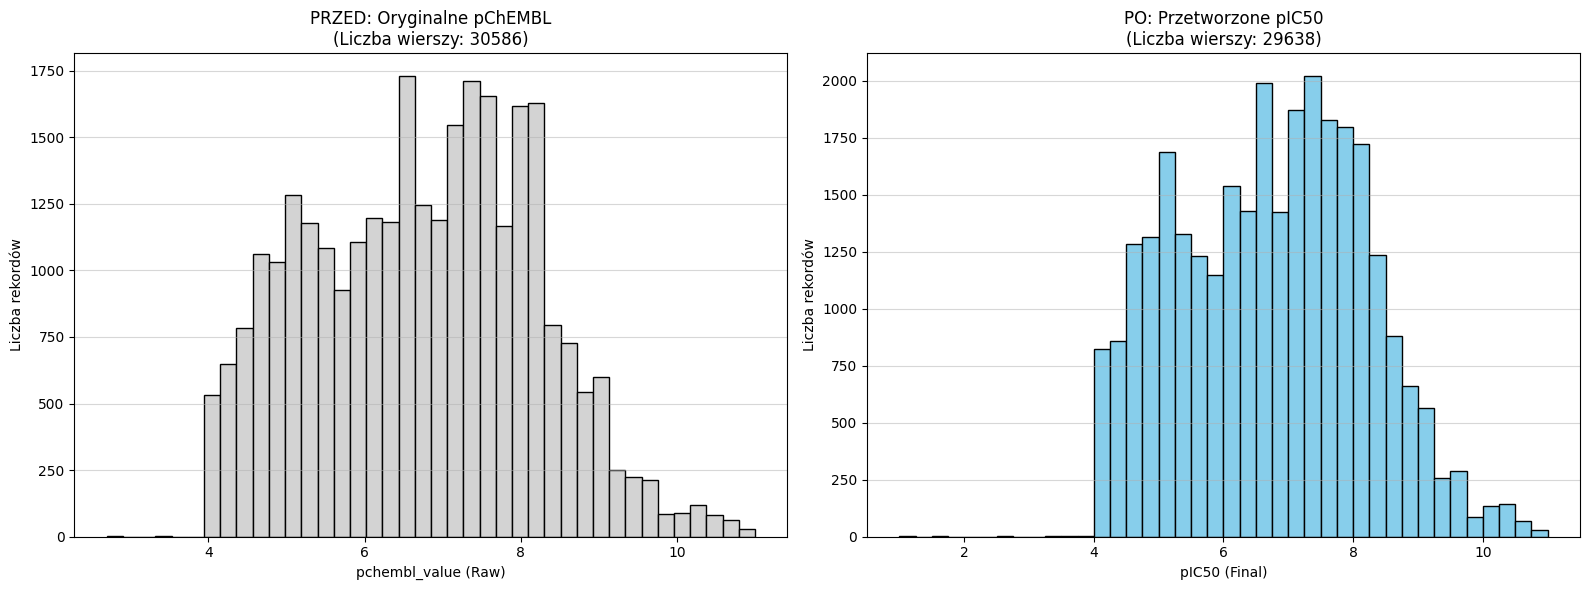

In [63]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].hist(df_before['pchembl_value'].dropna(), bins=40, color='lightgray', edgecolor='black')
axes[0].set_xlabel('pchembl_value (Raw)')
axes[0].set_ylabel('Liczba rekordów')
axes[0].set_title(f'PRZED: Oryginalne pChEMBL\n(Liczba wierszy: {len(df_before)})')
axes[0].grid(axis='y', alpha=0.5)

axes[1].hist(df['pchembl_value'].dropna(), bins=40, color='skyblue', edgecolor='black')
axes[1].set_xlabel('pIC50 (Final)')
axes[1].set_ylabel('Liczba rekordów')
axes[1].set_title(f'PO: Przetworzone pIC50\n(Liczba wierszy: {len(df)})')
axes[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

In [64]:
df['potential_duplicate'].value_counts()

,count
potential_duplicate,
0,20576
1,9062


Usuwanie znanych duplikatów

In [65]:
df = df[df['potential_duplicate'] == False]
df.drop(columns=['potential_duplicate'], inplace=True)
print(len(df))

20576


Grupowanie wierszy będących z dużym prawdopodobieństwem duplikatami, i pozostawienie po jednym

In [66]:
import pandas as pd
import numpy as np

df = df.reset_index(drop=True)

target_id_col = next((col for col in ['molecule_chembl_id', 'target_name', 'tid'] if col in df.columns), 'target_name')
mol_col = 'standard_inchi_key' if 'standard_inchi_key' in df.columns else 'canonical_smiles'
value_col = 'pchembl_value'

potential_cols = [mol_col, target_id_col, 'organism', 'standard_type', 'bao_format']
group_cols = [c for c in potential_cols if c in df.columns]

for col in group_cols:
    df[col] = df[col].fillna('Unknown')

print(f"Rows before cleaning: {len(df)}")
print(f"Grouping by: {group_cols}")

stats = df.groupby(group_cols)[value_col].agg(['mean', 'std', 'count'])

threshold = 1.0
conflict_mask = (stats['count'] > 1) & (stats['std'] > threshold)
conflicting_groups = stats[conflict_mask]
valid_groups = stats[~conflict_mask]

if not conflicting_groups.empty:
    print(f"\nFound {len(conflicting_groups)} conflicting groups. Top examples:")
    top_conflicts = conflicting_groups.sort_values('std', ascending=False).head(3)

    for idx, row in top_conflicts.iterrows():
        print(f"\nConflict Group Keys: {list(zip(group_cols, idx))}")
        print(f"Stats: StdDev={row['std']:.2f} | Count={int(row['count'])}")

        mask = pd.Series(True, index=df.index)
        for col_name, val in zip(group_cols, idx):
            mask &= (df[col_name] == val)

        cols_to_show = ['activity_id', 'standard_value', 'standard_type', 'bao_format', value_col]
        display(df[mask][[c for c in cols_to_show if c in df.columns]])

df_dedup = df.groupby(group_cols).first().reset_index()
df_final = pd.merge(df_dedup, valid_groups[['mean']], on=group_cols, how='inner')

df_final[value_col] = df_final['mean']
df_final = df_final.drop(columns=['mean'])

print(f"\nRows after cleaning: {len(df_final)}")
print(f"Removed total: {len(df) - len(df_final)}")

Rows before cleaning: 20576
Grouping by: ['standard_inchi_key', 'target_name', 'organism', 'standard_type', 'bao_format']

Found 342 conflicting groups. Top examples:

Conflict Group Keys: [('standard_inchi_key', 'SGTNSNPWRIOYBX-UHFFFAOYSA-N'), ('target_name', 'MCF7'), ('organism', 'Unknown'), ('standard_type', 'IC50'), ('bao_format', 'BAO_0000219')]
Stats: StdDev=3.31 | Count=5


,activity_id,standard_value,standard_type,bao_format,pchembl_value
13559,824709,0.10,IC50,BAO_0000219,1.00
13811,18557534,1500.00,IC50,BAO_0000219,5.82
13890,25057395,87830.00,IC50,BAO_0000219,4.06
13954,26124246,1.02,IC50,BAO_0000219,8.99
13955,26124248,2.68,IC50,BAO_0000219,8.57



Conflict Group Keys: [('standard_inchi_key', 'RGLYKWWBQGJZGM-ISLYRVAYSA-N'), ('target_name', 'MCF7'), ('organism', 'Unknown'), ('standard_type', 'IC50'), ('bao_format', 'BAO_0000219')]
Stats: StdDev=2.90 | Count=2


,activity_id,standard_value,standard_type,bao_format,pchembl_value
8031,216752,5000.0,IC50,BAO_0000219,5.3
8140,25029721,0.4,IC50,BAO_0000219,9.4



Conflict Group Keys: [('standard_inchi_key', 'AIXAANGOTKPUOY-UHFFFAOYSA-N'), ('target_name', 'Acetylcholinesterase'), ('organism', 'Mus musculus'), ('standard_type', 'Ki'), ('bao_format', 'BAO_0000221')]
Stats: StdDev=2.77 | Count=2


,activity_id,standard_value,standard_type,bao_format,pchembl_value
8757,1274078,66000.0,Ki,BAO_0000221,4.18
8758,1274079,8.0,Ki,BAO_0000221,8.10



Rows after cleaning: 8965
Removed total: 11611


In [67]:
df = df_final

In [68]:
df['confidence_score'].value_counts()

,count
confidence_score,
8,2932
1,2353
9,2265
4,551
0,397
6,171
7,159
5,129
3,8


### ⚠️ Decyzja o braku filtrowania po `confidence_score`

Mimo obecności kolumny `confidence_score` w metadanych, w procesie ETL **zdecydowano się nie odrzucać** rekordów o niższym indeksie pewności (np. < 9). Decyzja ta podyktowana była trzema kluczowymi czynnikami:

1.  **Różnorodność chemiczna:** Testy o niższym `confidence_score` (np. testy funkcjonalne vs wiązania bezpośredniego) często zawierają unikalne szkielety chemiczne, które nie występują w standardowych testach wysokoprzepustowych. Ich usunięcie zubożyłoby przestrzeń chemiczną, którą model ma poznać.
2.  **Wystarczalność innych filtrów:** Zastosowano silne filtry na poziomie typu pomiaru (`standard_type` np. IC50) oraz relacji (`standard_relation = '='`). Uznano, że gwarantują one wystarczającą jakość danych, czyniąc dodatkowy filtr po `confidence_score` zbędnym ograniczeniem.

In [69]:
df.head(3)

,standard_inchi_key,target_name,organism,standard_type,bao_format,activity_id,assay_id,chembl_id,canonical_smiles,standard_value,...,hba,hbd,psa,rtb,num_ro5_violations,max_phase,assay_type,confidence_score,units_norm,value_molar
0,AAKMJFSTMUYOCW-SQQVDAMQSA-N,Muscarinic acetylcholine receptor,Rattus norvegicus,IC50,BAO_0000249,617705,138779,CHEMBL6375,C/C=C/COc1noc2c1CNCC2.Cl,14000.0,...,4.0,1.0,47.29,3.0,0.0,NaN,B,4,nm,0.000014
1,AANKYZBKRDCCHT-IUODEOHRSA-N,CEM-SS,Unknown,IC50,BAO_0000219,806769,43029,CHEMBL7633,CCCc1cc(=O)oc2c3c(c4c(c12)OC(C)(C)C=C4)O[C@H](...,18000.0,...,5.0,0.0,65.74,3.0,0.0,NaN,F,1,nm,0.000018
2,AAOVKJBEBIDNHE-UHFFFAOYSA-N,Acetylcholinesterase,Electrophorus electricus,Ki,BAO_0000357,12481274,909636,CHEMBL12,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21,13000.0,...,2.0,0.0,32.67,1.0,0.0,4.0,B,9,nm,0.000013


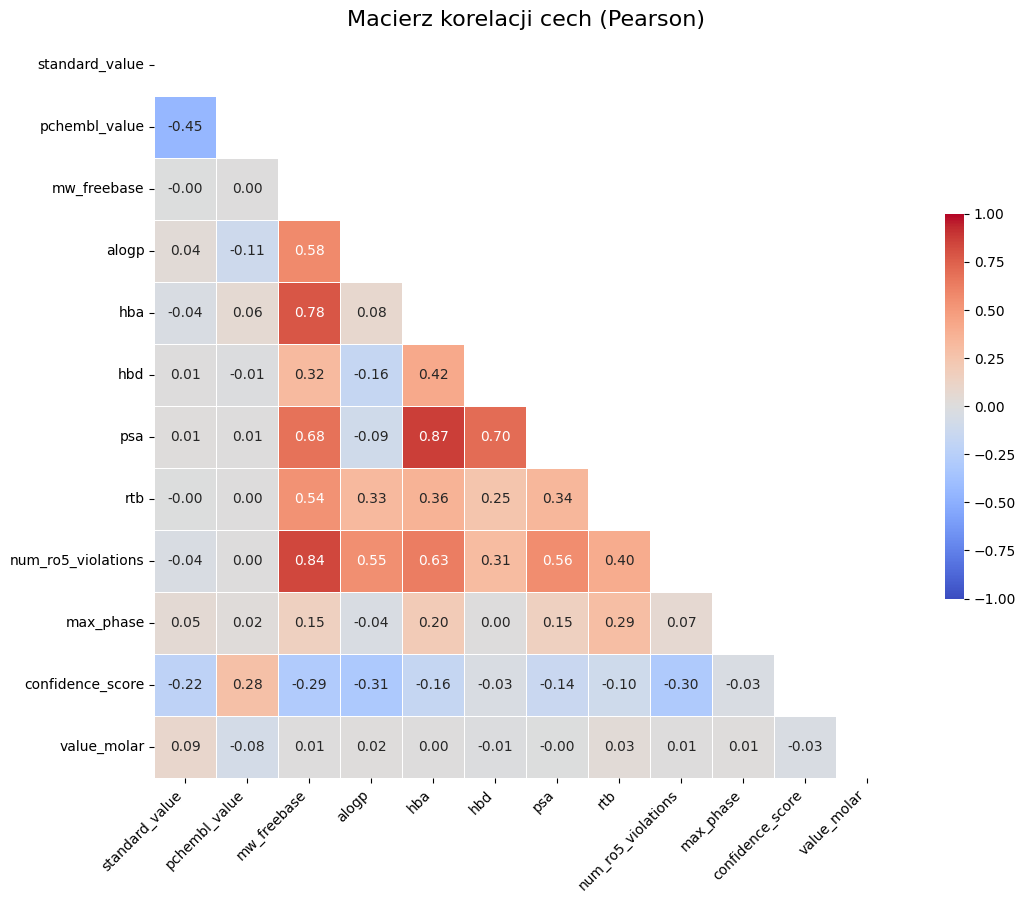

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cols_to_drop = ['activity_id', 'assay_id', 'molregno', 'tid', 'src_id', 'component_id']

df_corr = df.select_dtypes(include=['float64', 'int64', 'float32']).copy()

df_corr = df_corr.drop(columns=[c for c in cols_to_drop if c in df_corr.columns])

corr_matrix = df_corr.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmax=1, vmin=-1,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

plt.title('Macierz korelacji cech (Pearson)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

Dlaczego usuwanie od korelacji 0.75?
W chemii medycznej pewne zależności są silne, ale nie idealne (ok. 0.7–0.8):

PSA vs (HBA + HBD): Powierzchnia polarna (PSA) wynika wprost z liczby tlenów i azotów. Korelacja często wynosi ok. 0.8.

MW vs RTB: Im cięższa cząsteczka, tym zazwyczaj ma więcej wiązań rotacyjnych. Korelacja ok. 0.7.

Scalowanie, feature encoding

In [71]:
import pandas as pd
import numpy as np

# Definicja cech priorytetowych (Reguła Piątki Lipinskiego)
ro5_features = ['mw_freebase', 'alogp', 'hba', 'hbd']

numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()

cols_to_exclude = ['pchembl_value', 'activity_id', 'standard_value', 'molregno', 'tid']
feature_cols = [c for c in numeric_cols if c not in cols_to_exclude]

corr_matrix = df_final[feature_cols].corr().abs()

threshold = 0.75

to_drop = set()

cols = corr_matrix.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if corr_matrix.iloc[i, j] > threshold:
            col_a = cols[i]
            col_b = cols[j]

            is_a_ro5 = col_a in ro5_features
            is_b_ro5 = col_b in ro5_features

            if is_a_ro5 and not is_b_ro5:
                to_drop.add(col_b)
                print(f"Konflikt: {col_a} vs {col_b} -> Usuwam {col_b} (Chronię Ro5)")

            elif is_b_ro5 and not is_a_ro5:
                to_drop.add(col_a)
                print(f"Konflikt: {col_a} vs {col_b} -> Usuwam {col_a} (Chronię Ro5)")

            else:
                if col_a not in to_drop:
                    to_drop.add(col_b)

print(f"\nLista cech do usunięcia: {list(to_drop)}")

df_reduced = df_final.drop(columns=list(to_drop))

print(f"Liczba cech przed: {len(feature_cols)}")
print(f"Liczba cech po: {len(feature_cols) - len(to_drop)}")

df = df_reduced.copy()

Konflikt: mw_freebase vs num_ro5_violations -> Usuwam num_ro5_violations (Chronię Ro5)
Konflikt: hba vs psa -> Usuwam psa (Chronię Ro5)

Lista cech do usunięcia: ['hba', 'psa', 'num_ro5_violations']
Liczba cech przed: 11
Liczba cech po: 8


Outliery

🔍 Analizuję outliery dla: ['pchembl_value', 'mw_freebase', 'alogp', 'hbd']


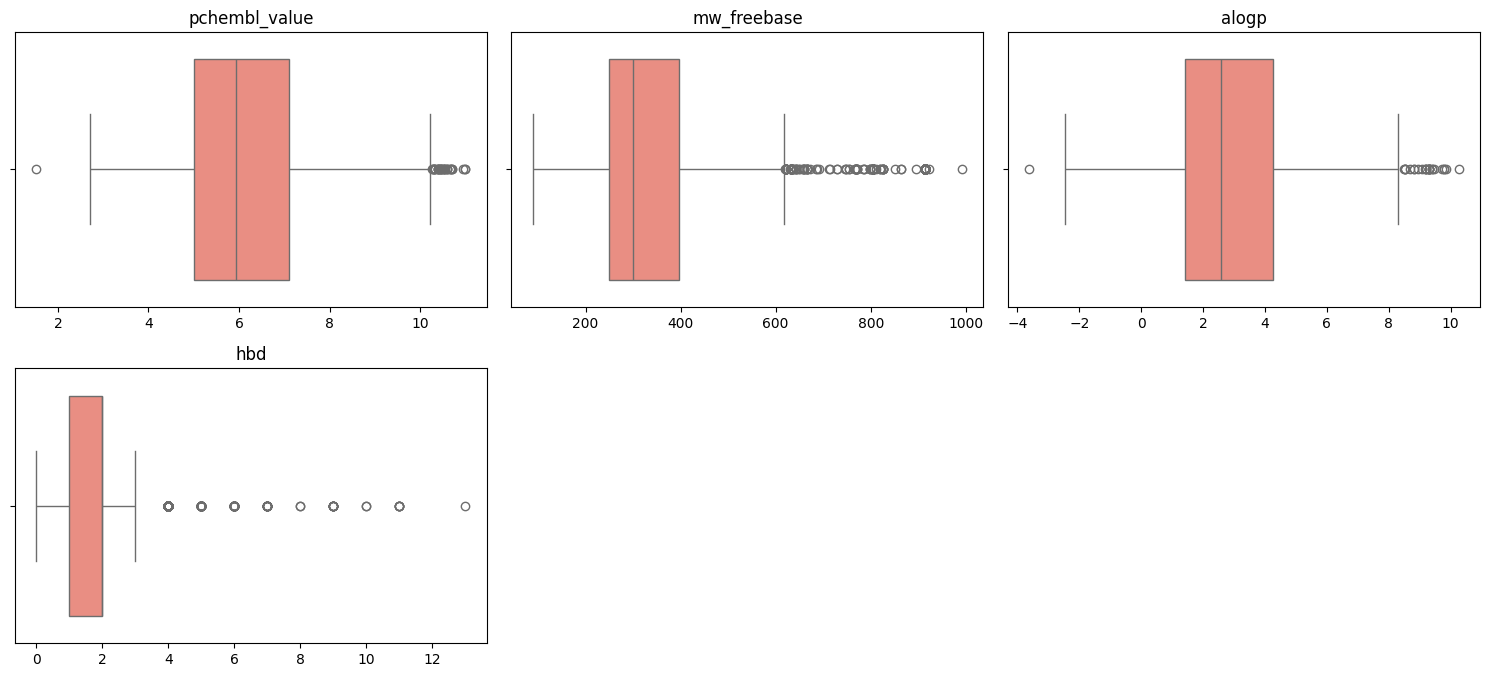


📊 STATYSTYKA OUTLIERÓW (Metoda 1.5 * IQR):
Cecha                | Dolna granica   | Górna granica   | Liczba Outlierów | % Zbioru  
------------------------------------------------------------------------------------------
pchembl_value        | 1.85            | 10.25           | 34              | 0.38     %
mw_freebase          | 27.08           | 618.12          | 551             | 6.15     %
alogp                | -2.83           | 8.50            | 28              | 0.31     %
hbd                  | -0.50           | 3.50            | 404             | 4.51     %

🦕 Najcięższe cząsteczki (Top 3 MW):


,canonical_smiles,mw_freebase,pchembl_value
4697,CCCN(NC(=O)[C@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H]...,992.05,5.1
7714,CCCN(NC(=O)[C@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H]...,921.96,5.1
5410,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,914.19,4.8



🚀 Najaktywniejsze cząsteczki (Top 3 pIC50):


,canonical_smiles,mw_freebase,pchembl_value
6988,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1,300.44,11.00
4606,Clc1ccc(C2CC3CCC2N3)cn1,208.69,11.00
5485,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,914.19,10.94


In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

outlier_features = [
    'pchembl_value',
    'mw_freebase',
    'alogp',
    'hba',
    'hbd',
    'psa',
    'num_ro5_violations'
]

features_to_check = [c for c in outlier_features if c in df.columns]

print(f"🔍 Analizuję outliery dla: {features_to_check}")

plt.figure(figsize=(15, 10))

for i, col in enumerate(features_to_check):
    plt.subplot(3, 3, i+1)

    data = pd.to_numeric(df[col], errors='coerce').dropna()

    sns.boxplot(x=data, color='salmon')
    plt.title(col, fontsize=12)
    plt.xlabel('')

plt.tight_layout()
plt.show()

print("\n📊 STATYSTYKA OUTLIERÓW (Metoda 1.5 * IQR):")
print(f"{'Cecha':<20} | {'Dolna granica':<15} | {'Górna granica':<15} | {'Liczba Outlierów':<15} | {'% Zbioru':<10}")
print("-" * 90)

outlier_indices = set()

for col in features_to_check:
    data = pd.to_numeric(df[col], errors='coerce').dropna()

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    count = len(outliers)
    percent = (count / len(data)) * 100

    print(f"{col:<20} | {lower_bound:<15.2f} | {upper_bound:<15.2f} | {count:<15} | {percent:<9.2f}%")

    if col != 'pchembl_value':
        outlier_indices.update(outliers.index)

if 'mw_freebase' in df.columns:
    print(f"\n🦕 Najcięższe cząsteczki (Top 3 MW):")
    top_mw = df.sort_values(by='mw_freebase', ascending=False).head(3)
    display(top_mw[['canonical_smiles', 'mw_freebase', 'pchembl_value']])

print(f"\n🚀 Najaktywniejsze cząsteczki (Top 3 pIC50):")
if 'pchembl_value' in df.columns:
    top_active = df.sort_values(by='pchembl_value', ascending=False).head(3)
    display(top_active[['canonical_smiles', 'mw_freebase', 'pchembl_value']])

### Decyzja o zachowaniu wartości odstających (Outliers)

Na podstawie analizy statystycznej (metoda IQR) zidentyfikowano punkty odstające, m.in. dla masy cząsteczkowej (`mw_freebase` > 618 Da) oraz aktywności (`pchembl_value` > 10.25). **Podjęto decyzję o pozostawieniu tych rekordów w zbiorze treningowym.**

**Uzasadnienie:**
1.  **Najcenniejsze dane (High Potency):** Wartości `pchembl_value` powyżej 10.0 (nanomolarne aktywności) mogą reprezentować najsilniejsze, najbardziej pożądane leki. Ich usunięcie pozbawiłoby model kluczowej wiedzy o tym, jakie cechy determinują wysoką skuteczność.
2.  **Współczesna chemia leków (Beyond Rule of 5):** Wiele nowoczesnych leków (np. inhibitory kinaz, makrocykle) przekracza masę 500-600 Da. Traktowanie ich jako błędy byłoby niepoprawne merytorycznie.
3.  **Poprawność fizyczna:** Wartości te mieszczą się w granicach fizycznej możliwości (brak błędów typu `MW = 0` czy `LogP = 100`).

Zamiast usuwania, zastosowane zostanie odpowiednie skalowanie danych (np. `StandardScaler` lub `RobustScaler`), aby zminimalizować wpływ skrajnych wartości na stabilność treningu sieci neuronowej.

In [73]:
from sklearn.preprocessing import StandardScaler

num_cols = ['mw_freebase', 'alogp', 'hbd', 'rtb']

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [74]:
if 'bao_endpoint' in df.columns:
    df = df.drop(columns=['bao_endpoint'])

df = df.reset_index(drop=True)

In [75]:
import pandas as pd

df_encoded = df.copy()

top_n = 5
top_organisms = df_encoded['organism'].value_counts().nlargest(top_n).index.tolist()

print(f"Top {top_n} organisms: {top_organisms}")

df_encoded['organism_group'] = df_encoded['organism'].apply(
    lambda x: x if x in top_organisms else 'Other'
)

categorical_cols = ['standard_type', 'bao_format', 'organism_group']

encoded_dummies = pd.get_dummies(df_encoded[categorical_cols], prefix=['type', 'bao', 'org'], dtype=int)

df_encoded = pd.concat([df_encoded, encoded_dummies], axis=1)

print(f"\nLiczba kolumn przed encodingiem: {df_clean.shape[1]}")
print(f"Liczba kolumn po encodingu: {df_encoded.shape[1]}")

new_cols = [c for c in df_encoded.columns if c.startswith(('type_', 'bao_', 'org_'))]
print("\nNowe kolumny (cechy dla modelu):")
print(new_cols)

display(df_encoded[new_cols].head(3))
df = df_encoded.copy()

Top 5 organisms: ['Homo sapiens', 'Unknown', 'Rattus norvegicus', 'Mus musculus', 'Bos taurus']

Liczba kolumn przed encodingiem: 27
Liczba kolumn po encodingu: 51

Nowe kolumny (cechy dla modelu):
['bao_format', 'type_AC50', 'type_EC50', 'type_GI50', 'type_IC50', 'type_Kd', 'type_Ki', 'bao_BAO_0000019', 'bao_BAO_0000217', 'bao_BAO_0000218', 'bao_BAO_0000219', 'bao_BAO_0000220', 'bao_BAO_0000221', 'bao_BAO_0000223', 'bao_BAO_0000224', 'bao_BAO_0000225', 'bao_BAO_0000249', 'bao_BAO_0000251', 'bao_BAO_0000252', 'bao_BAO_0000357', 'bao_BAO_0000366', 'org_Bos taurus', 'org_Homo sapiens', 'org_Mus musculus', 'org_Other', 'org_Rattus norvegicus', 'org_Unknown']


,bao_format,type_AC50,type_EC50,type_GI50,type_IC50,type_Kd,type_Ki,bao_BAO_0000019,bao_BAO_0000217,bao_BAO_0000218,...,bao_BAO_0000251,bao_BAO_0000252,bao_BAO_0000357,bao_BAO_0000366,org_Bos taurus,org_Homo sapiens,org_Mus musculus,org_Other,org_Rattus norvegicus,org_Unknown
0,BAO_0000249,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,BAO_0000219,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,BAO_0000357,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


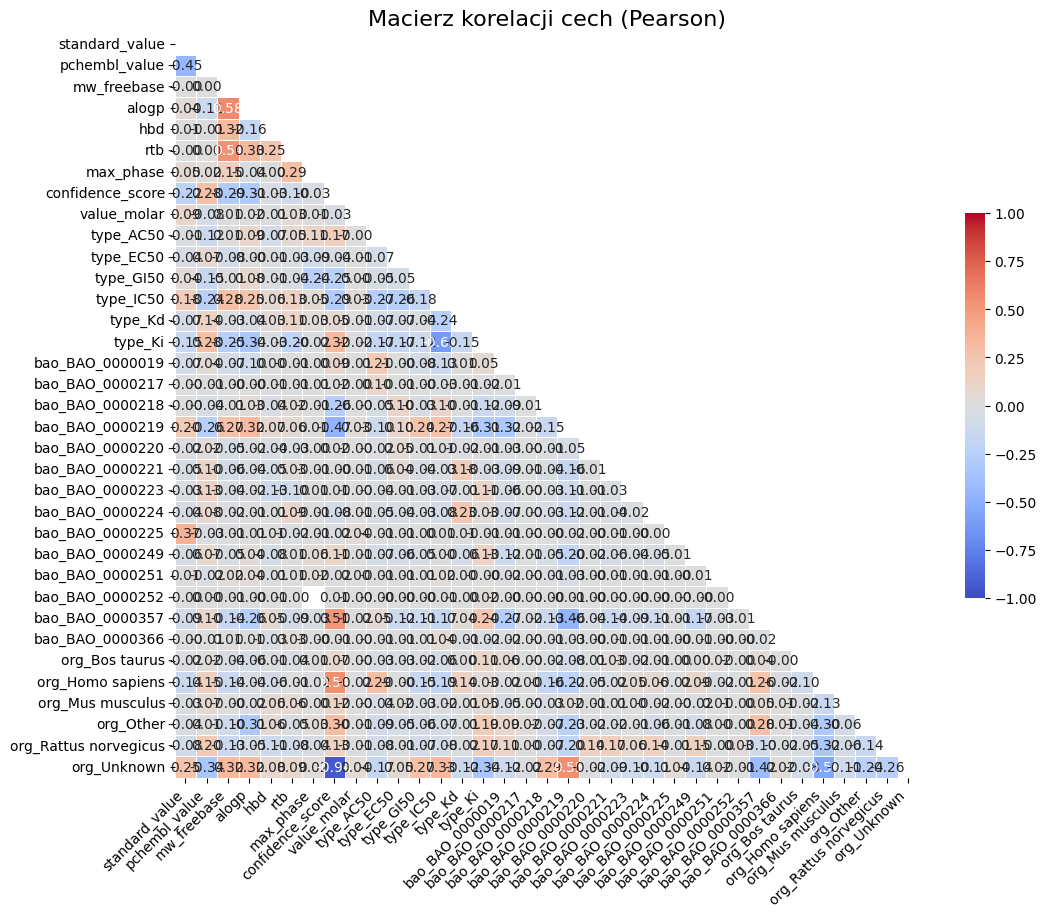

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cols_to_drop = ['activity_id', 'assay_id', 'molregno', 'tid', 'src_id', 'component_id']

df_corr = df.select_dtypes(include=['float64', 'int64', 'float32']).copy()

df_corr = df_corr.drop(columns=[c for c in cols_to_drop if c in df_corr.columns])

corr_matrix = df_corr.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmax=1, vmin=-1,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

plt.title('Macierz korelacji cech (Pearson)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

In [77]:
cols_to_drop = [
    'standard_type', 'bao_format', 'organism', 'organism_group',

    'activity_id', 'assay_id', 'standard_inchi_key',
    'target_name',

    'data_validity_comment', 'activity_comment', 'assay_type',

    'standard_value', 'value_molar', 'standard_units', 'units_norm', 'standard_relation',

    'max_phase', 'confidence_score'
]

existing_cols_to_drop = [c for c in cols_to_drop if c in df.columns]

df_ml = df.drop(columns=existing_cols_to_drop)

print(f"Usunięto {len(existing_cols_to_drop)} kolumn.")
print(f"Ostateczny kształt danych do modelu: {df_ml.shape}")

print("\nTypy danych w df_ml (powinny być tylko liczbowe):")
print(df_ml.dtypes.value_counts())

df = df_ml.copy()

Usunięto 18 kolumn.
Ostateczny kształt danych do modelu: (8965, 33)

Typy danych w df_ml (powinny być tylko liczbowe):
int64      26
float64     5
object      2
Name: count, dtype: int64


In [78]:
print(f"Unikalne ID? {df.index.nunique() == len(df)}")

Unikalne ID? True


In [79]:
import pandas as pd

print(f"--- PODSUMOWANIE KOŃCOWE ---")
print(f"Liczba wierszy: {df.shape[0]}")
print(f"Liczba kolumn:  {df.shape[1]}")

final_report = pd.DataFrame({
    'Typ Danych (Dtype)': df.dtypes,
    'Wypełnione (Non-Null)': df.count(),
    'Braki (Null)': df.isnull().sum(),
    '% Braków': (df.isnull().sum() / len(df_reduced) * 100).round(2)
})

final_report = final_report.sort_values(by='Braki (Null)', ascending=False)

print("\nSzczegółowa lista kolumn:")
display(final_report)

target_col = 'pchembl_value'
if target_col in df_reduced.columns:
    print(f"\nStatystyki dla celu '{target_col}':")
    print(f"Min: {df_reduced[target_col].min()}")
    print(f"Max: {df_reduced[target_col].max()}")
    print(f"Średnia: {df_reduced[target_col].mean():.2f}")

--- PODSUMOWANIE KOŃCOWE ---
Liczba wierszy: 8965
Liczba kolumn:  33

Szczegółowa lista kolumn:


,Typ Danych (Dtype),Wypełnione (Non-Null),Braki (Null),% Braków
chembl_id,object,8965,0,0.0
canonical_smiles,object,8965,0,0.0
pchembl_value,float64,8965,0,0.0
mw_freebase,float64,8965,0,0.0
alogp,float64,8965,0,0.0
hbd,float64,8965,0,0.0
rtb,float64,8965,0,0.0
type_AC50,int64,8965,0,0.0
type_EC50,int64,8965,0,0.0
type_GI50,int64,8965,0,0.0



Statystyki dla celu 'pchembl_value':
Min: 1.5228787452803376
Max: 11.0
Średnia: 6.14


Zostało bardzo mało danych, ale można było temu zaradzić przenosząc filtrowanie do Postgresa. Wtedy dla limitu 1 000 000 udało mi się uzyskać ok 600 000 wierszy po transformacjach.

OCENA WAŻNOŚCI CECH (FEATURE IMPORTANCE) - Metoda XGBoost

✅ Wybrane cechy do analizy: ['mw_freebase', 'alogp', 'hbd', 'rtb']
🎯 Zmienna celu: pchembl_value


/tmp/ipython-input-367476045.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Waznosc', y='Cecha', data=feature_imp_df, palette='viridis')


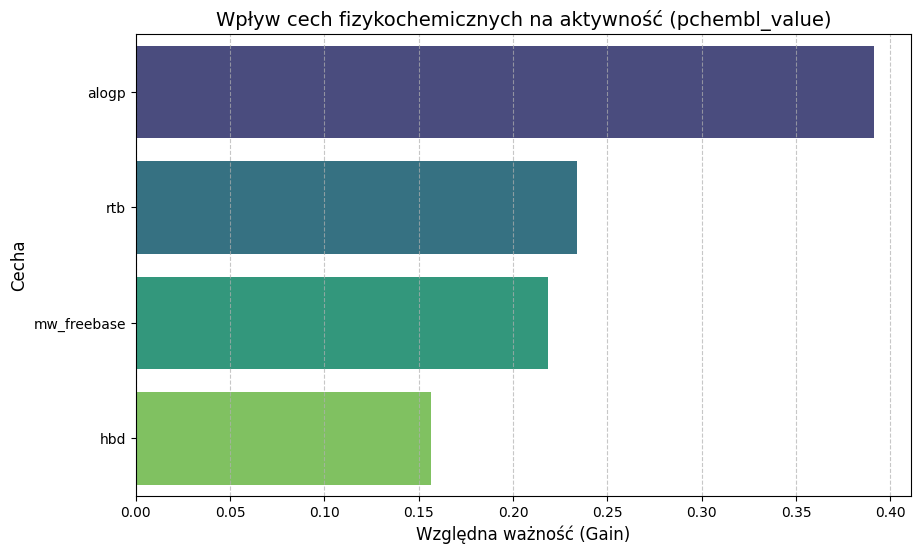


📋 Ranking cech:


,Cecha,Waznosc
1,alogp,0.391228
3,rtb,0.233911
0,mw_freebase,0.218600
2,hbd,0.156260


In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

candidate_features = [
    'mw_freebase',
    'alogp',
    'hbd',
    'rtb',
    'num_ro5_violations',
    'confidence_score'
]

features = [col for col in candidate_features if col in df.columns]

target_col = 'pchembl_value' if 'pchembl_value' in df.columns else 'target'

print(f"✅ Wybrane cechy do analizy: {features}")
print(f"🎯 Zmienna celu: {target_col}")

X = df[features].copy()
y = df[target_col]

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

y = pd.to_numeric(y, errors='coerce').fillna(y.mean())

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
model.fit(X, y)

importances = model.feature_importances_
feature_imp_df = pd.DataFrame({
    'Cecha': features,
    'Waznosc': importances
})

feature_imp_df = feature_imp_df.sort_values(by='Waznosc', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Waznosc', y='Cecha', data=feature_imp_df, palette='viridis')

plt.title(f'Wpływ cech fizykochemicznych na aktywność ({target_col})', fontsize=14)
plt.xlabel('Względna ważność (Gain)', fontsize=12)
plt.ylabel('Cecha', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("\n📋 Ranking cech:")
display(feature_imp_df)